In [16]:
import numpy as np
import matplotlib.pyplot as plt
from util.logger import EventTracker
from util.basis_scaled import *
from util.plot_tools import *
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from hmm.stokes import *
from itertools import product
from hmm.stokes_deep import DeepMicroSolver, get_net
import matplotlib
import torch.nn as nn
import matplotlib as mpl

#matplotlib.rcParams['text.usetex'] = True
#pretty_pyplot_layout()

np.random.seed(0)
net_dir = "/mnt/data0/emastr/article_training_nodecay/"
figures_dir = "/home/emastr/deep-micro-slip-model/data/figures/"
run_dir = "/home/emastr/deep-micro-slip-model/data/reference_2/"

#save_dir = "/home/emastr/deep-micro-slip-model/data/hmm_coupling_error/"
save_dir = "/mnt/data0/emastr/hmm_coupling/"
deep_save_dir = "/mnt/data0/emastr/hmm_coupling_deep/"

In [17]:
from dataclasses import dataclass
from multiprocessing import Pool
from architecture.session import egeofno_ver1, egeofno_ver2, egeofno_ver3, egeofno_ver4, svdfno_ver1, svdfno_ver2, svdfno_ver3, svdfno_ver4
import torch

device = "cpu"
nets = [egeofno_ver1, egeofno_ver2, egeofno_ver3, egeofno_ver4, svdfno_ver1, svdfno_ver2, svdfno_ver3, svdfno_ver4]

@dataclass
class HyperParams:
    nMic: int
    xDim: int
    yDim: int
    width: float
    height: float
    tol: float
    max_iter: int
    num_pts: int
    net_path: str = None
    net_type: int = None
    
    
class Setup():
    def __init__(self, data: StokesData, param: HyperParams):#, net: nn.Module, net_settings: dict):
        """Create a new HMM setup with the given parameters."""
        self.params = param
        self.data = data
        
        # Macro problem
        macro = StokesMacProb(data, lambda x,a: fft_interp(x, a, dom=data.dom[0]))
        macro_solver = MacroSolver(param.xDim, param.yDim, tol=param.tol)
        
        # Net setup
        net = nets[param.net_type](device=device)
        net_data = torch.load(param.net_path, map_location=torch.device(device))
        net.load_state_dict(net_data["state dict"])
        net_settings =  {"num_pts": param.num_pts, "input_features": net_data["settings"]["input_features"], "device": device, "dtype": torch.float}
        
        # Micro problems
        self.xPos = np.linspace(data.dom[0][0], data.dom[0][1], param.nMic+1)[1:] - param.width/2 - (data.dom[0][1]-data.dom[0][0]) / param.nMic/1
        micros = [StokesTrapezMicProb(data, x, param.width, param.height, 0.0, 8, param.xDim, param.yDim, num_pts=param.num_pts) for x in self.xPos]
        #micros = [StokesMicProb(data, x, param.width, param.height, 0.0, 8, param.xDim, param.yDim, n_refine=1) for x in self.xPos]
        #micro_solvers = [MicroSolver(m, tol=param.tol) for m in micros]
        deep_micro_solvers = [DeepMicroSolver(m, net, net_settings, tol=param.tol) for m in micros]
        
        # Convergence checker
        conv_checker = ConvergenceChecker(macro, micros, tol=param.tol)
        
        # HMM problem
        self.hmm_problem = StokesHMMProblem(macro, micros, data, convergence_checker=conv_checker)
        #self.hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)
        self.hmm_deep_solver = IterativeHMMSolver(macro_solver, deep_micro_solvers)
        
        
    def solve(self, **kwargs):
        macro_guess = self.hmm_deep_solver.macro_solver.solve(self.hmm_problem.macro)
        (macro_sol, micro_sols) = self.hmm_deep_solver.solve(self.hmm_problem, macro_guess=macro_guess, verbose=True, maxiter=self.params.max_iter, tol=self.params.tol)
        #(deep_macro_sol, deep_micro_sols) = self.hmm_deep_solver.solve(self.hmm_problem, macro_guess=macro_guess, verbose=True, maxiter=self.params.max_iter, tol=self.params.tol)
        
        return micro_sols, macro_sol, macro_guess #deep_micro_sols, deep_macro_sol, macro_guess
    
    
    def save_sol(self, macro_sol, filename):
        data = self.params.__dict__
        data['mic_sol'] = [m.r for m in self.hmm_deep_solver.micro_solvers]
        data['sol_u'] = macro_sol.u.eval_grid()
        data['sol_v'] = macro_sol.v.eval_grid()
        #data['deep_sol_u'] = deep_macro_sol.u.eval_grid()
        #data['deep_sol_v'] = deep_macro_sol.v.eval_grid()
        #print(np.linalg.norm(data['sol_u'] - data['deep_sol_u'])/np.linalg.norm(data['sol_u']))
        np.save(filename, data)
        
    @staticmethod
    def load_sol(filename):
        data = np.load(filename, allow_pickle=True).flatten()[0]
        u = data.pop('sol_u')
        v = data.pop('sol_v')
        m = data.pop('mic_sol')
        #u_deep = data.pop('deep_sol_u')
        #v_deep = data.pop('deep_sol_v')
        par = HyperParams(**data)
        return par, u, v, m#, u_deep, v_deep

In [18]:
net_paths = [f"fno_ver{i}_seed{j}" for i in range(1, 5) for j in range(1, 4)] + \
            [f"svd_ver{i}_seed{j}" for i in range(1, 5) for j in range(1, 4)]

net_type_idxs = [i for i in range(4) for j in range(3) ] +\
                [4 + i for i in range(4) for j in range(3) ]

idx = 1
print(net_paths)
print(net_paths[idx], net_type_idxs[idx], nets[idx])

i_list = [2, 42-16, 42, 42+16]#, 74]
e_list = [0.001, 0.005, 0.01, 0.04]

i = i_list[0]
e = e_list[0]

num_pts = 256
print(net_paths[0])

data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
data_big_domain = data
dom = data.dom
eps = info["eps"]
n = 7
w = 5


params = HyperParams(nMic=n, xDim=21, yDim=21, width=w*eps, 
                        height=w*eps*0.8, tol=1e-8, max_iter=30, num_pts=num_pts,
                        net_path=f"{net_dir}{net_paths[idx]}_40000.Torch", net_type=net_type_idxs[idx])
setup = Setup(data, params)

micro_sols, macro_sol, macro_guess = setup.solve()#deep_micro_sols, deep_macro_sol, macro_guess
setup.save_sol(macro_sol, f"{deep_save_dir}hmm_coupling_{i}.npy")

['fno_ver1_seed1', 'fno_ver1_seed2', 'fno_ver1_seed3', 'fno_ver2_seed1', 'fno_ver2_seed2', 'fno_ver2_seed3', 'fno_ver3_seed1', 'fno_ver3_seed2', 'fno_ver3_seed3', 'fno_ver4_seed1', 'fno_ver4_seed2', 'fno_ver4_seed3', 'svd_ver1_seed1', 'svd_ver1_seed2', 'svd_ver1_seed3', 'svd_ver2_seed1', 'svd_ver2_seed2', 'svd_ver2_seed3', 'svd_ver3_seed1', 'svd_ver3_seed2', 'svd_ver3_seed3', 'svd_ver4_seed1', 'svd_ver4_seed2', 'svd_ver4_seed3']
fno_ver1_seed2 0 <function egeofno_ver2 at 0x7f42f7182020>
fno_ver1_seed1
Convergence (not necessarily to solution) at step 8/30


[0.20691353312595764, 0.030276796004025077, 0.006641369706413538, 0.0016597835951147205, 0.0007382640213373582, 0.0005716380566808125, 0.00019804810901264566, 0.00019342399665800054, 0.0001723832345218969, 7.240752983611544e-05, 5.687205141874234e-05]
[0.32294996525775227, 0.04774145652204382, 0.010221662668827009, 0.0021388153935129094, 0.0006412233447909763, 0.000223322577264394, 8.533681175808642e-05, 1.9118319526003782e-05, 2.1527338887866227e-05, 3.1628089626433314e-06, 9.052656165717734e-06]
[0.2581589466129818, 0.03572866049966119, 0.009067353645458019, 0.0015277815365630249, 0.0005338394704972253, 0.00019328791949729495, 6.917102636320022e-05, 2.1922107402081455e-05, 8.725420040732187e-06, 2.2563342684161758e-06, 1.0622016972122913e-06]
[0.21613173968209123, 0.03050805332270052, 0.006620736417723594, 0.001254876979631206, 0.00044395418912166845, 0.00016308291281658772, 5.612230070151194e-05, 1.884934048486828e-05, 7.418635464917604e-06, 2.230313914134072e-06, 7.87428696935756e-

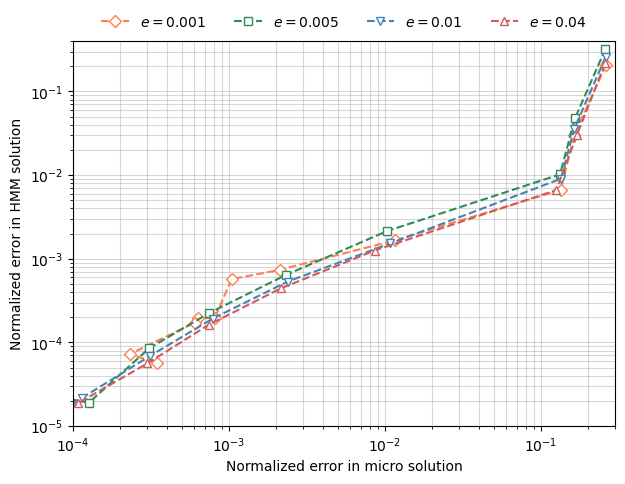

In [12]:
import os
step = [1, 2, 3, 4, 6, 8, 11, 16, 22, 32, 46, 64]#, 128]
M_list = [s * 20 for s in step]
i_list = [2, 42-16, 42, 42+16]#, 74]
e_list = [0.001, 0.005, 0.01, 0.04]
#colors = ["indigo", "tomato", "firebrick", "mediumseagreen"]
colors = ["coral", "seagreen", "steelblue", "indianred"]
markers = ["D", "s", "v", "^"]

plt.figure(figsize=(7,5))
micro_error = []
for j, i in enumerate(i_list):
    param_true, u_true, v_true, micsol_true = Setup.load_sol(f"{save_dir}big_run_{i}_{M_list[-1]}_sol.npy")
    coupling_error = []
    micro_error = []
    data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
    #u_true_eps = data["Ux"]
    for s, m in zip(step[:-1], M_list[:-1]):
        param, u, v, micsol = Setup.load_sol(f"{save_dir}big_run_{i}_{m}_sol.npy")
        #print(f"Error for sim {i} with {m} discretisation points")
        (N, M) = u.shape
        eps = info["eps"]
        mask = np.linspace(0, 1, M) < eps*np.log(1/eps)
        u_mask = u[:, mask]
        u_true_mask = u_true[:, mask]
        
        if i >= 2:
            micro_error.append(np.linalg.norm(micsol[0][::s] - micsol_true[0][::step[-1]])/np.linalg.norm(micsol_true[0][::step[-1]]))
        if False:#((i == 2) and (m in [20, 20*46])):
            plt.figure(2)
            plt.plot(micsol[0][::s], label=f"$M = {m}$")
            
        plt.figure(1)
        coupling_error.append(np.linalg.norm(u_mask - u_true_mask)/np.linalg.norm(u_true_mask))
    #plt.plot(M_list[:-1], coupling_error, label=f"$epsilon = {eps:.0e}$")
    plt.plot(micro_error, coupling_error, markers[j]+"--", color=colors[j], label=f"$e = {e_list[j]}$",  markerfacecolor='white')
    print(coupling_error)


error_hmm_deep = []
error_micro_deep = []
for path in os.listdir(deep_save_dir):
    if path.endswith(".npy"):
        data = np.load(f"{deep_save_dir}{path}", allow_pickle=True).flatten()[0]
        u = data.pop('sol_u')
        v = data.pop('sol_v')
        m = data.pop('mic_sol')
        u_deep = data.pop('deep_sol_u')
        v_deep = data.pop('deep_sol_v')
        par = HyperParams(**data)
        error_hmm_deep.append(np.linalg.norm(u - u_deep)/np.linalg.norm(u))
        error_micro_deep.append(np.linalg.norm(m[0] - m[1])/np.linalg.norm(m[1]))
    
    
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Normalized error in micro solution")
plt.ylabel("Normalized error in HMM solution")
plt.grid(which="both", alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=False, shadow=False, ncol=4, frameon=False)
#plt.gca().spines["right"].set_visible(False)
#plt.gca().spines["top"].set_visible(False)
plt.xlim([0.0001, .3])
plt.ylim([1e-5, 4e-1])
plt.gcf().savefig(f"{figures_dir}coupling_error.pdf")
    


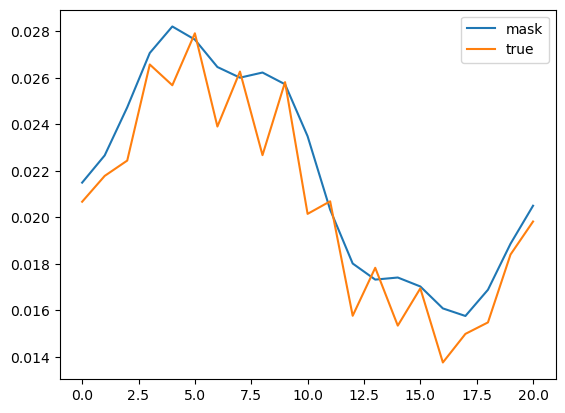

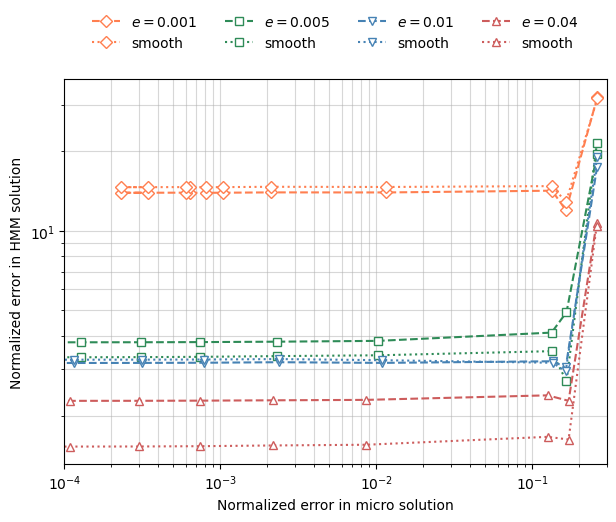

In [9]:
step = [1, 2, 3, 4, 6, 8, 11, 16, 22, 32, 46, 64]#, 128]
M_list = [s * 20 for s in step]
i_list = [2, 42-16, 42, 42+16]#, 74]
e_list = [0.001, 0.005, 0.01, 0.04]
#colors = ["indigo", "tomato", "firebrick", "mediumseagreen"]
colors = ["coral", "seagreen", "steelblue", "indianred"]
markers = ["D", "s", "v", "^"]

plt.figure(1, figsize=(7,5))
micro_error = []
for j, i in enumerate(i_list):
    param_true, u_true, v_true, micsol_true = Setup.load_sol(f"{save_dir}big_run_{i}_{M_list[-1]}_sol.npy")
    coupling_error = []
    micro_error = []
    smooth_coupling_error = []
    data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
    X = info["X"]
    Y = info["Y"]
    Uc = info["Uc"]
    U_interp = PiecewiseInterp2D(X[0], Y[:, 0], Uc)
    
    #u_true_eps = data["Ux"]
    for s, m in zip(step[:-1], M_list[:-1]):
        param, u, v, micsol = Setup.load_sol(f"{save_dir}big_run_{i}_{m}_sol.npy")
        #print(f"Error for sim {i} with {m} discretisation points")
        (N, M) = u.shape
        eps = info["eps"]
        #mask = np.linspace(0, 1, M) < eps*np.log(1/eps)
        #u_mask = u[:, 0]
        #print(data.dom)
        basis = ScaleShiftedBasisProduct.fromFunctionInDomain(lambda x, y: u, data.dom, 21, 21, FourBasis, ChebBasis)
        basis_true = ScaleShiftedBasisProduct.fromFunctionInDomain(lambda x, y: U_interp(x, y), [[-1, 1], [0.01, 0.4]], 11, 21, FourBasis, ChebBasis)
        #u_true_mask = u_true[:, 0]
        x, y = np.linspace(-1, 1, len(u_mask)+1)[:-1], np.zeros(len(u_mask)) + 0.01
        u_mask = basis(x, y)
        u_true_smooth_mask = basis_true(x, y)
        u_true_mask = U_interp(x, y)
        
        if j == 3 and s == 32:
            plt.figure(2)
            plt.plot(u_mask, label="mask")
            plt.plot(u_true_mask, label="true")
            plt.legend()
            
        micro_error.append(np.linalg.norm(micsol[0][::s] - micsol_true[0][::step[-1]])/np.linalg.norm(micsol_true[0][::step[-1]]))
        coupling_error.append(np.linalg.norm(u_mask - u_true_mask)/np.linalg.norm(u_true_mask)/eps)
        smooth_coupling_error.append(np.linalg.norm(u_true_smooth_mask - u_mask)/np.linalg.norm(u_true_mask)/eps)
    #plt.plot(M_list[:-1], coupling_error, label=f"$epsilon = {eps:.0e}$")
    plt.figure(1)
    plt.plot(micro_error, coupling_error, markers[j]+"--", color=colors[j], label=f"$e = {e_list[j]}$",  markerfacecolor='white')
    plt.plot(micro_error, smooth_coupling_error, markers[j]+":", color=colors[j], label=f"smooth",  markerfacecolor='white')
    #print(coupling_error)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Normalized error in micro solution")
plt.ylabel("Normalized error in HMM solution")
plt.grid(which="both", alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          fancybox=False, shadow=False, ncol=4, frameon=False)
#plt.gca().spines["right"].set_visible(False)
#plt.gca().spines["top"].set_visible(False)
plt.xlim([0.0001, .3])
#plt.ylim([1e-5, 4e-1])
plt.gcf().savefig(f"{figures_dir}hmm_error.pdf")
    


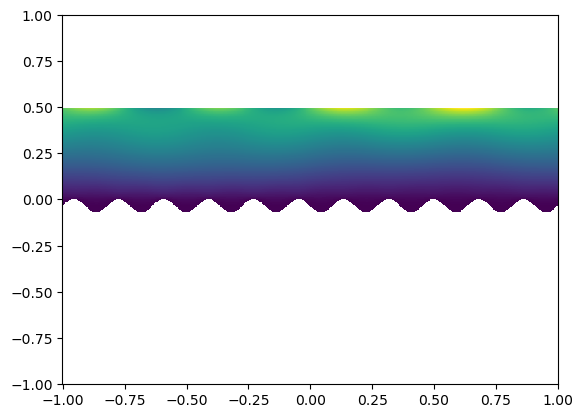

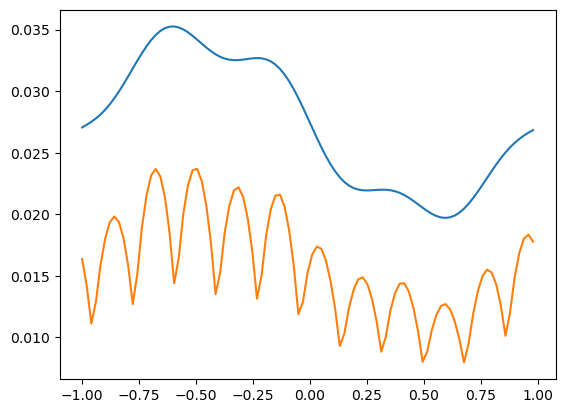

In [10]:
from scipy.interpolate import RegularGridInterpolator
X = info["X"]
Y = info["Y"]
U = info["Uc"]


#print(X.shape, Y.shape, U.shape)
#help(interp2d)
basis = ScaleShiftedBasisProduct.fromFunctionInDomain(lambda x, y: u, [[-1, 1], [0, 0.5]], 21, 21, FourBasis, ChebBasis)
U_interp = PiecewiseInterp2D(X[0], Y[:, 0], U)


#plt.pcolormesh(X, Y, 0*X)
plt.pcolormesh(X, Y, U_interp(X.flatten(), Y.flatten()).reshape(X.shape))  


plt.figure()
x, y = np.linspace(-1, 1, 100)[:-1], np.zeros(100-1) + 0.005
#plt.plot(np.linspace(0,1,512), U[256, :])
#print(U[300,:])
plt.plot(x, basis(x, y))
plt.plot(x, U_interp(x, y))


KeyboardInterrupt: 

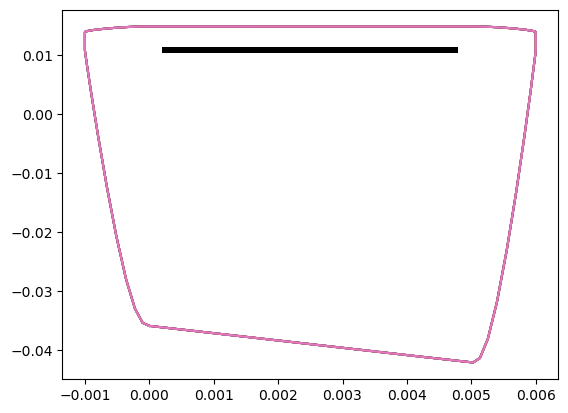

In [11]:
vecs = []
step = [1, 2, 4, 8, 16, 32, 64, 128]
M_list = [s * 16 for s in step]
for m in M_list:
    problem = StokesTrapezMicProb(data, 0.0, params.width, params.height, 0.0, 8, params.xDim, params.yDim, num_pts=m)
    solver = MicroSolver(problem, tol=1e-10)
    vecs.append(solver.avg_vec)
    problem.plot(plt.gca())
    

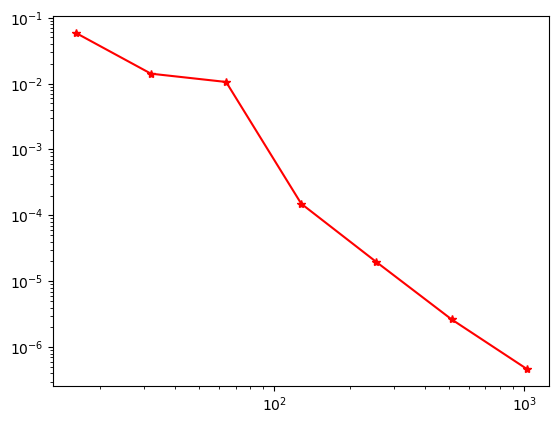

In [ ]:
vec_downsamp = [r[::s] for r,s in zip(vecs, step)]
error = [np.linalg.norm(v - vec_downsamp[-1])/np.linalg.norm(vecs[-1]) for v in vec_downsamp[:-1]]

plt.loglog(M_list[:-1], error, 'r*-')

In [ ]:
# range of data to use : 25 - 59
    
w_list = [3]
n_list = [13]
num_pts = [m]
i_list = list(range(50, 60, 1))

args = [(i, n, w) for i, n, w in product(i_list, n_list, w_list)]

def solve_save(i, n, w):
    data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
    data_big_domain = data
    dom = data.dom
    eps = info["eps"]
    print(f"i={i}, (n={n}, w={w}")
    params = HyperParams(nMic=n, xDim=21, yDim=21, width=w*eps, height=w*eps*0.8, tol=1e-8, max_iter=30, num_pts=m)
    setup = Setup(data, params)
    micro_sols, macro_sol, macro_guess = setup.solve()
    setup.save_sol(macro_sol, f"{save_dir}/sol_{i}_{n}_{w}.npy")

In [ ]:

Pool(8).starmap(solve_save, args)

i=50, (n=13, w=3
i=52, (n=13, w=3i=54, (n=13, w=3i=53, (n=13, w=3i=55, (n=13, w=3i=56, (n=13, w=3i=57, (n=13, w=3





i=51, (n=13, w=3
